# Movie review text sentiment analysis
# - 네이버 영화리뷰 감성분석 프로젝트

## 1. 데이터 준비 및 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성
- 특수문자 제거
- 데이터 중복 제거
- 공백은 NULL로 변경
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(stopwords)제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    #특수문자 제거
    train_data['document'] = train_data['document'].str.replace(pat = r'[^\w]', repl=r'', regex=True)
    #중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    #공백은 Null로 변경
    train_data['document'].replace('', np.nan, inplace=True)
    #결측치 제거
    train_data = train_data.dropna(how = 'any')
    
    #특수문자 제거
    test_data['document'] = test_data['document'].str.replace(pat = r'[^\w]', repl=r'', regex=True)    
    #중복 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    #공백은 Null로 변경
    test_data['document'].replace('', np.nan, inplace=True)
    #결측치 제거
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_test.append(temp_X)
    
    #단어 사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    #리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

#데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print('train data : {}, test data : {}'.format(len(X_train), len(X_test)))

#인덱스:단어 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

train data : 143763, test data : 48535


In [3]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수. 
#모든 문장은 <BOS>로 시작해야 함. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

#여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

#숫자 벡터로 encode된 문장을 원래대로 decode하는 함수. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

#여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#decode 된 문장과 라벨 비교 후 일치하는지 확인
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[32, 70, 893, 33, 222, 15, 39, 2, 473]
더 빙 진짜 짜증 나 네 <UNK> 소리
라벨:  0
[1066, 493, 345, 653, 4, 112, 1577, 47, 789, 1014, 11, 38, 383]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1
[19, 167, 2]
재 <UNK>
라벨:  0
[8573, 144, 4237, 278, 92, 13, 5, 50, 3502]
이야기 구먼 솔직히 재미 없 다 평점 조정
라벨:  0
[2, 9132, 1054, 47, 2693, 54, 4, 2694, 34, 1142, 29, 325, 37, 17, 36, 54, 2, 392, 3442, 1717, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> 너무나 이뻐 보였 다
라벨:  1
[713, 2, 2, 131, 414, 171, 1488, 666, 65, 1593, 715, 45, 446, 183, 265, 4, 62, 1400, 133, 751]
<UNK> <UNK> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 ㅋㅋㅋ 별반 개 아까움
라벨:  0
[237, 359, 8, 355, 1976, 53, 11, 805, 5]
긴장감 을 제대로 살려 내 지 못했 다
라벨:  0
[1400, 133, 147, 5, 442, 729, 2, 2, 47, 1456, 273, 91, 232, 24, 961, 22, 324, 593, 523, 483, 575, 5, 3169, 8574, 17, 1429, 1429, 66, 284, 13, 5, 47, 98, 7, 69, 17, 2, 39]
개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만 <UNK> 네
라벨:  0
[120, 13, 18, 88, 273, 23, 43, 4]
없 는데 재미있 몇 안 되

## 3. 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 활용한 패딩

In [4]:
#텍스트 데이터 문장 길이의 리스트 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

#문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

#최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됨. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장길이 평균 :  13.83758541430488
문장길이 최대 :  105
문장길이 표준편차 :  11.5584486916598
pad_sequences maxlen :  36
전체 문장의 93.27658113968944%가 maxlen 설정값 이내에 포함됨. 


In [5]:
#padding으로 문장 길이 맞춤.

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                                     padding='post', maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(143763, 36)


In [6]:
#훈련용 데이터셋 중 40000건을 분리하여 validation set으로 사용
x_val = X_train[:40000]
y_val = y_train[:40000]

#validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(103763, 36)
(103763,)


## 4. 모델 구성, 훈련, 평가 및 분석
### - 3가지 이상 다양하게 구성하여 실험.
-  LSTM 레이어 모델
- 1-D CNN 레이어 모델
- GlobalMaxPooling1D만 레이어로 하는 모델

### 4.1 LSTM 레이어 모델

In [7]:
#LSTM

#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)
word_vector_dim = 16  

#LSTM 레이어로 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  #LSTM state 벡터의 차원수
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [8]:
#LSTM 레이어 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
203/203 [==============================] - 6s 16ms/step - loss: 0.6734 - accuracy: 0.5439 - val_loss: 0.4582 - val_accuracy: 0.8148
Epoch 2/5
203/203 [==============================] - 2s 11ms/step - loss: 0.4114 - accuracy: 0.8319 - val_loss: 0.3905 - val_accuracy: 0.8239
Epoch 3/5
203/203 [==============================] - 2s 11ms/step - loss: 0.3445 - accuracy: 0.8548 - val_loss: 0.3638 - val_accuracy: 0.8384
Epoch 4/5
203/203 [==============================] - 2s 11ms/step - loss: 0.3213 - accuracy: 0.8657 - val_loss: 0.3706 - val_accuracy: 0.8357
Epoch 5/5
203/203 [==============================] - 2s 11ms/step - loss: 0.3084 - accuracy: 0.8695 - val_loss: 0.3840 - val_accuracy: 0.8323


In [9]:
#LSTM 레이어 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 5s - loss: 0.3938 - accuracy: 0.8291
[0.393847793340683, 0.8290718197822571]


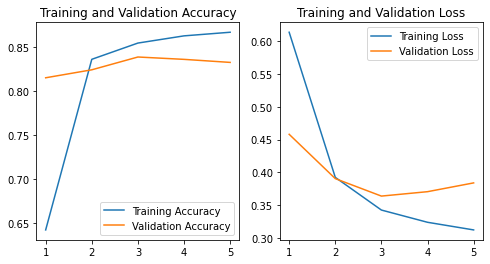

In [10]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4.2 1-D CNN 레이어 모델

In [11]:
##1-D CNN 모델

#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)
word_vector_dim = 16  

#1-D CNN 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [12]:
#1-D CNN 레이어 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
203/203 [==============================] - 8s 24ms/step - loss: 0.6304 - accuracy: 0.6409 - val_loss: 0.3759 - val_accuracy: 0.8331
Epoch 2/5
203/203 [==============================] - 2s 9ms/step - loss: 0.3495 - accuracy: 0.8488 - val_loss: 0.3585 - val_accuracy: 0.8405
Epoch 3/5
203/203 [==============================] - 2s 9ms/step - loss: 0.3041 - accuracy: 0.8714 - val_loss: 0.3596 - val_accuracy: 0.8420
Epoch 4/5
203/203 [==============================] - 2s 9ms/step - loss: 0.2767 - accuracy: 0.8858 - val_loss: 0.3666 - val_accuracy: 0.8424
Epoch 5/5
203/203 [==============================] - 2s 8ms/step - loss: 0.2484 - accuracy: 0.8998 - val_loss: 0.3788 - val_accuracy: 0.8387


In [13]:
#1-D CNN 레이어 모델평가

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 4s - loss: 0.3864 - accuracy: 0.8359
[0.38643819093704224, 0.8358504176139832]


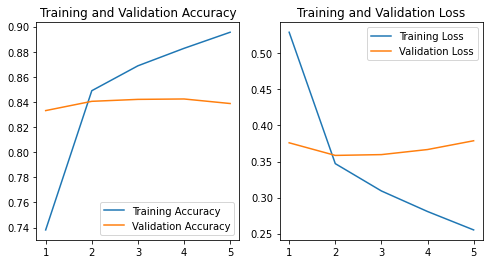

In [14]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4.3 GlobalMaxPooling 1D 레이어만 사용한 모델

In [15]:
#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수(변경가능)
word_vector_dim = 16  

#GlobalMaxPooling1D레이어 하나만 사용한 모델
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [16]:
#GlobalMaxPooling1D레이어 하나만 사용한 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
203/203 [==============================] - 2s 6ms/step - loss: 0.6741 - accuracy: 0.6188 - val_loss: 0.5142 - val_accuracy: 0.7979
Epoch 2/5
203/203 [==============================] - 1s 6ms/step - loss: 0.4618 - accuracy: 0.8161 - val_loss: 0.3916 - val_accuracy: 0.8260
Epoch 3/5
203/203 [==============================] - 1s 6ms/step - loss: 0.3604 - accuracy: 0.8483 - val_loss: 0.3727 - val_accuracy: 0.8351
Epoch 4/5
203/203 [==============================] - 1s 5ms/step - loss: 0.3218 - accuracy: 0.8659 - val_loss: 0.3694 - val_accuracy: 0.8365
Epoch 5/5
203/203 [==============================] - 1s 6ms/step - loss: 0.2981 - accuracy: 0.8763 - val_loss: 0.3731 - val_accuracy: 0.8362


In [17]:
##GlobalMaxPooling1D레이어 하나만 사용한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 2s - loss: 0.3815 - accuracy: 0.8325
[0.38148069381713867, 0.832450807094574]


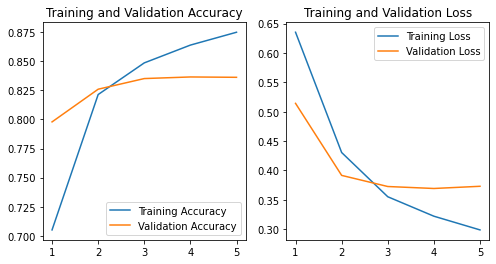

In [18]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5. 학습된 Embedding 레이어 분석

In [19]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

#임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    

(10000, 16)


In [20]:
import os
#학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

#단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
#파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

#유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("행복")

[('뛰어난', 0.8986629247665405),
 ('우수', 0.8690185546875),
 ('라구요', 0.8598381280899048),
 ('의장', 0.8477360010147095),
 ('좋아한다', 0.844957172870636),
 ('널리', 0.8199489116668701),
 ('졸이', 0.8149664402008057),
 ('미니', 0.8145254850387573),
 ('내린', 0.8123903274536133),
 ('안겨준', 0.8091134428977966)]

- 출력된 유사성이 떨어지는 단어들을 보고 학습이 잘 되지 않았다는 것을 알 수 있음.

## 6. 한국어 Word2Vec Embedding 활용

In [22]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

#유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("행복") 

[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [23]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     #어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  #워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [24]:
#모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [25]:
#학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1622/1622 [==============================] - 37s 21ms/step - loss: 0.5582 - accuracy: 0.6716 - val_loss: 0.3478 - val_accuracy: 0.8458
Epoch 2/5
1622/1622 [==============================] - 34s 21ms/step - loss: 0.3132 - accuracy: 0.8643 - val_loss: 0.3319 - val_accuracy: 0.8523
Epoch 3/5
1622/1622 [==============================] - 34s 21ms/step - loss: 0.2570 - accuracy: 0.8929 - val_loss: 0.3282 - val_accuracy: 0.8579
Epoch 4/5
1622/1622 [==============================] - 33s 20ms/step - loss: 0.2166 - accuracy: 0.9116 - val_loss: 0.3477 - val_accuracy: 0.8554
Epoch 5/5
1622/1622 [==============================] - 32s 20ms/step - loss: 0.1821 - accuracy: 0.9274 - val_loss: 0.3941 - val_accuracy: 0.8526


In [26]:
#테스트셋 사용하여 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results) 

1517/1517 - 7s - loss: 0.4003 - accuracy: 0.8501
[0.4002564251422882, 0.8501081466674805]


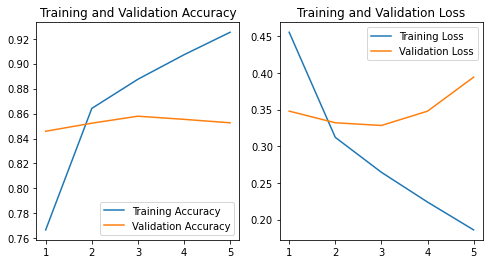

In [27]:
#Accuracy, Loss 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

---

# 프로젝트 정리
## - 정확도
- 노드에서 시도 해 보았던 LSTM, 1-D CNN, GlobalMaxPooling1D를 레이어로 가지는 각 3개의 모델로 학습을 했다.
- 각 모델로 학습 시킨 후 정확도가 각각 0.829, 0.835, 0.832가 나왔다.
- 당연히 사전 학습 된 한글 word2vec을 사용하여 모델을 학습시키면 정확도 역시 꽤 높아질 줄 알았는데 겨우겨우 0.850로 85%가 되었다.
- 하이퍼파라미터를 요리조리 바꾸어봐도 정확도가 85%보다 낮아지기만 하고 더 높아지진 않았다.
- 리뷰 텍스트 내에 맞춤법이 잘못 된 단어가 꽤 많이 보였는데 이런 문제들도 정확도와 관련이 있을 것 같다.
## - 에폭
- 처음에 각 3개의 모델에 대해서 에폭을 10으로 모델 학습을 시켰는데 accuracy와 loss를 시각화 했을 때 꽤 요상한 모양의 그래프가 나와서 5로 낮추어서 학습시켰다.
![에폭10](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex07/accuracy_loss_gp/epoch10.PNG?raw=true)
- validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해진다고 노드에서 봤던 것 같아서 10보다는 5 정도가 괜찮을 것 같다고 판단했기 때문이다.
## - 유사단어 찾기
- gensim의 유사단어 찾기를 해보았는데 사전 학습 된 한글 word2vec을 사용하려니 오류가 발생했었다. 
  - gensim의 버전이 최신 버전이라 파일을 로드하지 못하는 에러가 발생하여 gensim을 다운그레이드 해주었다.
- 자체 학습한 임베딩에서는 유사단어 찾기를 했을 때 관련성이 거의 없는 단어들이 많이 나왔는데 사전 학습된 임베딩에서는 꽤 유사성이 높은 단어들이 나왔다. 
- 행복에 대한 유사 단어 결과
  - 자체 학습한 임베딩 : 뛰어난, 우수, 라구요, 의장, 좋아한다, 널리, 졸이, 미니, 내린, 안겨준
  - 사전 학습된 임베딩 : 사랑, 기쁨, 즐거움, 삶, 젊음, 즐겁, 인생, 존엄, 고독, 불행